In [ ]:
!pip install -q flwr["simulation"] tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 14.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 39.3 MB/s eta 0:00:00


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# TensorFlow, tf.keras and tensorflow_federated
import tensorflow as tf
from tensorflow import keras
# import tensorflow_federated as tff

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import functools
import glob
import os
import PIL
import time
# import flwr as fl\

# Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [ ]:
# tf2.0 setting
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# Constants
Round = 300
Clinets_per_round = 10
Batch_size = 2048
Gan_epoch = 10
Test_accuracy = []
Test_loss = []
Models = { }
Client_data = {}
Client_labels = {}

BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 36
num_to_merge = 500
# num_to_merge = 50
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_merge = tf.random.normal([num_to_merge, noise_dim])

attack_count = 0

In [ ]:
#########################################################################
##               Load Data              ##
#########################################################################

# Data
# FASHION_MNIST
(train_images, train_labels_r), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_labels = np.copy(train_labels_r)
# MNIST
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')


test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5   # Normalization

state = np.random.get_state()

# train_labels.setflags(write = 1)

# Change the order
np.random.shuffle(train_images)
np.random.set_state(state)
np.random.shuffle(train_labels)


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(train_images)
# print(train_labels)

In [ ]:
print(train_images.flags)
print(train_labels.flags)
print(test_images.flags)
print(test_images.flags)
print(train_labels)

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
# Sample to warm up
# Starting with a very low learning rate to tune attention of the network
warm_up_data = train_images[0:3000]
warm_up_labels = train_labels[0:3000]

# Each Client owns different data, Attacker has no targeted samples
for i in range(Clinets_per_round):
    # Client_data.update({i:np.vstack((np.vstack((train_images[train_labels==i], train_images[train_labels==(i+1)%9])), train_images[train_labels==(i+2)%9]))})
    # Client_labels.update({i:np.append(np.append(train_labels[train_labels==i], train_labels[train_labels==(i+1)%9]), train_labels[train_labels==(i+2)%9])})

    # One for 5 classes
    # Client_data.update({i:train_images[train_labels==(i*5)]})
    # Client_labels.update({i:train_labels[train_labels==(i*5)]})
    # for j in range(4):
    #     Client_data[i] = np.vstack((Client_data[i], train_images[train_labels==(i+j+1)]))
    #     Client_labels[i] = np.append(Client_labels[i], train_labels[train_labels==(i+j+1)])

    # Each Client has one class
    Client_data.update({i:train_images[train_labels==i]})
    Client_labels.update({i:train_labels[train_labels==i]})
    # Shuffle
    state = np.random.get_state()
    np.random.shuffle(Client_data[i])
    np.random.set_state(state)
    np.random.shuffle(Client_labels[i])
    # print(len(train_labels[train_labels==i]))

attack_ds = np.array(Client_data[0])
attack_l = np.array(Client_labels[0])

In [ ]:
#########################################################################
##            Models Prepared              ##
#########################################################################

# Models & malicious discriminator model
def make_discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(11))
    return model

# Malicious generator model
def make_generator_model():
    model = keras.Sequential()

    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Batch size is not limited

    model.add(keras.layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
# Model
# Sever‘s models
model = make_discriminator_model()

# Clients' models
for i in range(Clinets_per_round):
    Models.update({i:make_discriminator_model()})
    Models[i].compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#########################################################################
##              Attack setup              ##
#########################################################################

# Malicious gan
generator = make_generator_model()
malicious_discriminator = make_discriminator_model()

# Cross entropy
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#Loss of discriminator
def discriminator_loss(real_output, fake_output, real_labels):
    real_loss = cross_entropy(real_labels, real_output)

    fake_result = np.zeros(len(fake_output))
    # Attack label
    for i in range(len(fake_result)):
        fake_result[i] = 10
    fake_loss = cross_entropy(fake_result, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss





##############################################
#   这里没改，不然应该有更好的结果    #
##############################################

# Loss of generator
def generator_loss(fake_output):
    ideal_result = np.zeros(len(fake_output))
    # Attack label
    for i in range(len(ideal_result)):
        # The class which attacker intends to get
        ideal_result[i] = 3

    return cross_entropy(ideal_result, fake_output)

# Optimizer
#############################################################################################
# # decay dont work on tf2.3 or higher
# # Origional one
# generator_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, decay=1e-7)
# discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, decay=1e-7)
#############################################################################################
# Modified
lr_schedule_gen = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9999)
lr_schedule_dis = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9999)
generator_optimizer = keras.optimizers.SGD(learning_rate=lr_schedule_gen)
discriminator_optimizer = keras.optimizers.SGD(learning_rate=lr_schedule_dis)

# Training step
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # real_output is the probability of the mimic number
        real_output = malicious_discriminator(images, training=False)
        fake_output = malicious_discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, real_labels = labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, malicious_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, malicious_discriminator.trainable_variables))

# Train
def train(dataset, labels, epochs):
    for epoch in range(epochs):
        start = time.time()
        for i in range(round(len(dataset)/BATCH_SIZE)):
            image_batch = dataset[i*BATCH_SIZE:min(len(dataset), (i+1)*BATCH_SIZE)]
            labels_batch = labels[i*BATCH_SIZE:min(len(dataset), (i+1)*BATCH_SIZE)]
            train_step(image_batch, labels_batch)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Last epoch generate the images and merge them to the dataset
    generate_and_save_images(generator, epochs, seed)

# Generate images to check the effect
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    if attack_count >= Round - 50:
      fig = plt.figure(figsize=(6,6))

      for i in range(predictions.shape[0]):
         plt.subplot(6, 6, i+1)
         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
         plt.axis('off')

      plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))


In [ ]:
print(predictions.shape)
print(predictions.shape[0])

(500, 28, 28, 1)
500


In [ ]:
#########################################################################
##            Federated Learning             ##
#########################################################################

# Training Preparation
# Cconfig the model with losses and metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# warm up process
model.fit(warm_up_data, warm_up_labels, validation_split=0, epochs=25, batch_size = 256)
del train_images, train_labels

tmp_weight = model.get_weights()

attack_count = 0

# Federated learning
for r in range(Round):
    print('round:'+str(r+1))
    model_weights_sum = []
    # model_weight_tmp = []
    # tmp_weight = model.get_weights()

    for i in range(Clinets_per_round):

        # train the clients individually
        # if r != 0:
        #     Models[i].set_weights(tmp_weight)
        Models[i].set_weights(tmp_weight)

        train_ds = Client_data[i]
        train_l = Client_labels[i]

        # Attack (suppose client 0 is malicious)
        if r != 0 and i == 0 and Test_accuracy[i-1] > 0.85:

            print("Attack round: {}".format(attack_count+1))

            malicious_discriminator.set_weights(Models[i].get_weights())
            # train(attack_ds, attack_l, Gan_epoch)
            train(attack_ds, attack_l, Gan_epoch)


            # Setting of malicious images and its labels
            predictions = generator(seed_merge, training=False)
            malicious_images = np.array(predictions)
            malicious_labels = np.array([3]*len(malicious_images))

            # Merge the malicious images
            if attack_count == 0:
                Client_data[i] = np.vstack((Client_data[i], malicious_images))
                # Label the malicious images
                Client_labels[i] = np.append(Client_labels[i], malicious_labels)
            else:
                Client_data[i][len(Client_data[i])-len(malicious_images):len(Client_data[i])] = malicious_images

            attack_count += 1


        Models[i].fit(train_ds, train_l, validation_split=0, epochs=1, batch_size = Batch_size)

        if i == 0:
            model_weights_sum = np.array(Models[i].get_weights())
            # model_weight_tmp = np.array(Models[i].get_weights())
        else:
            model_weights_sum += np.array(Models[i].get_weights())
            # delta_weight = np.array(Models[i].get_weights()) - np.array(tmp_weight)
            # model_weight_tmp += delta_weight


    # averaging the weights
    mean_weight = np.true_divide(model_weights_sum,Clinets_per_round)
    tmp_weight = mean_weight.tolist()
    del model_weights_sum
    # tmp_weight = model_weight_tmp
    # del model_weight_tmp

    # evaluate
    model.set_weights(tmp_weight)
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    Test_accuracy.append(test_acc)
    Test_loss.append(test_loss)
    print('\nTest accuracy:', test_acc, 'Tset loss:', test_loss)

Epoch 1/25
12/12 [==============================] - 14s 45ms/step - loss: 1.3755 - accuracy: 0.5327
Epoch 2/25
12/12 [==============================] - 0s 19ms/step - loss: 0.7711 - accuracy: 0.7170
Epoch 3/25
12/12 [==============================] - 0s 13ms/step - loss: 0.6155 - accuracy: 0.7750
Epoch 4/25
12/12 [==============================] - 0s 15ms/step - loss: 0.5510 - accuracy: 0.8067
Epoch 5/25
12/12 [==============================] - 0s 14ms/step - loss: 0.5059 - accuracy: 0.8143
Epoch 6/25
12/12 [==============================] - 0s 14ms/step - loss: 0.4764 - accuracy: 0.8323
Epoch 7/25
12/12 [==============================] - 0s 13ms/step - loss: 0.4358 - accuracy: 0.8450
Epoch 8/25
12/12 [==============================] - 0s 14ms/step - loss: 0.4161 - accuracy: 0.8470
Epoch 9/25
12/12 [==============================] - 0s 16ms/step - loss: 0.3998 - accuracy: 0.8623
Epoch 10/25
12/12 [==============================] - 0s 14ms/step - loss: 0.3707 - accuracy: 0.8753
Epoch 11

<ipython-input-11-b284886fb4d4>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_weights_sum = np.array(Models[i].get_weights())


3/3 [==============================] - 2s 95ms/step - loss: 0.0590 - accuracy: 0.9845


<ipython-input-11-b284886fb4d4>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_weights_sum += np.array(Models[i].get_weights())


3/3 [==============================] - 1s 67ms/step - loss: 0.1565 - accuracy: 0.9505


3/3 [==============================] - 1s 69ms/step - loss: 0.1793 - accuracy: 0.9455


3/3 [==============================] - 1s 70ms/step - loss: 0.0684 - accuracy: 0.9778

Test accuracy: 0.8355000019073486 Tset loss: 0.5154975652694702
round:2
3/3 [==============================] - 0s 74ms/step - loss: 0.0500 - accuracy: 0.9825

Test accuracy: 0.8361999988555908 Tset loss: 0.505209743976593
round:3
3/3 [==============================] - 0s 70ms/step - loss: 0.0451 - accuracy: 0.9828

Test accuracy: 0.8352000117301941 Tset loss: 0.5016016960144043
round:4
3/3 [==============================] - 0s 72ms/step - loss: 0.0403 - accuracy: 0.9853

Test accuracy: 0.8357999920845032 Tset loss: 0.5004597306251526
round:5
3/3 [==============================] - 0s 73ms/step - loss: 0.0438 - accuracy: 0.9858

Test accuracy: 0.835099995136261 Tset loss: 0.4993424713611603
round:6
3/3 [==============================] - 0s 71ms/step - loss: 0.0389 - accuracy: 0.9868

Test accuracy: 0.8363000154495239 Tset loss: 0.49745815992355347
round:7
3/3 [==============================] - 0s 72ms/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
acc_s = np.array(Test_accuracy)
loss_s = np.array(Test_loss)

In [ ]:
with open('/content/drive/My Drive/GAN_Attack_FL/acc_300_att(fakelabel=3_GanEpoch10).txt', 'w') as f:
    np.savetxt(f, acc_s)
with open('/content/drive/My Drive/GAN_Attack_FL/loss_300_att(fakelabel=3_GenEpoch10).txt', 'w') as f:
    np.savetxt(f, loss_s)

In [ ]:
print(malicious_labels)
print('\n',Client_labels)

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 

In [ ]:
def plot_learn_curve(acc, loss, round):
    # Plot training and test loss
    t = np.arange(round)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(t, np.array(loss), 'b-')
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.legend(['Test Loss'])
    plt.savefig("FL_GAN_ATT_loss.png")

    # Plot Accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(t, acc, 'r-')
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.legend(['Test Accuracy'])
    plt.savefig("FL_GAN_ATT_accuracy.png")

In [ ]:
print(Test_accuracy)
print('\n',test_loss)
print('\n',Round)

[0.9546999931335449, 0.9538999795913696, 0.9550999999046326, 0.9545999765396118, 0.9546999931335449, 0.9550999999046326, 0.9549999833106995, 0.9553999900817871, 0.9556000232696533, 0.9569000005722046, 0.957099974155426, 0.9573000073432922, 0.9574999809265137, 0.9569000005722046, 0.9577999711036682, 0.9607999920845032, 0.9603000283241272, 0.9603000283241272, 0.960099995136261, 0.9606000185012817, 0.9607999920845032, 0.9610999822616577, 0.9610000252723694, 0.9621000289916992, 0.9623000025749207, 0.9609000086784363, 0.9610000252723694, 0.9609000086784363, 0.960099995136261, 0.9606999754905701, 0.9599000215530396, 0.9613999724388123, 0.9611999988555908, 0.9599999785423279, 0.9603999853134155, 0.9620000123977661, 0.9616000056266785, 0.9599000215530396, 0.9610999822616577, 0.9617000222206116, 0.9605000019073486, 0.9616000056266785, 0.9581000208854675, 0.9607999920845032, 0.961899995803833, 0.960099995136261, 0.9592000246047974, 0.9592000246047974, 0.9614999890327454, 0.9603000283241272, 0.95

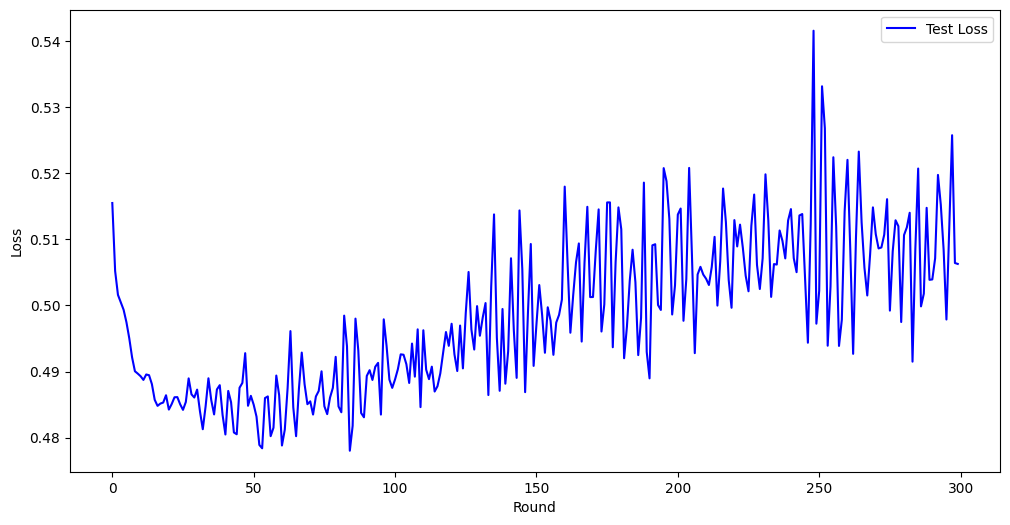

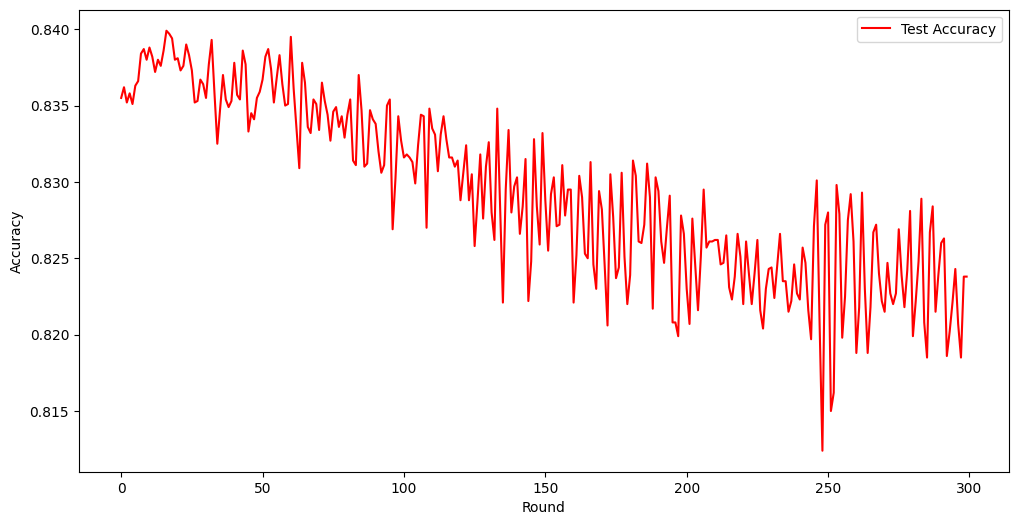

In [ ]:
plot_learn_curve(Test_accuracy, Test_loss, Round)

Abandoned

In [ ]:
def plot_learn_curve(train_acc, train_loss, test_acc, test_loss, Round):
    # Plot training and test loss
    t = np.arange(Round - 1)

    plt.figure(figsize=(6, 6))
    plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig("FL_GAN_ATT_loss.png")

    # Plot Accuracies
    plt.figure(figsize=(6, 6))
    plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
    plt.xlabel("Round")
    plt.ylabel("Accuray")
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig("FL_GAN_ATT_accuracy.png")

Flower Part

In [ ]:
class FlowerClient(fl.client.NumPyClient):

#####################################################################################################
#    def __init__(self, model, x_train, y_train, x_val, y_val) -> None:        #
#        self.model = model                               #
#        self.x_train, self.y_train = x_train, y_train                 #
#        self.x_val, self.y_val = x_val, y_val                     #
#####################################################################################################

# Initialize of model and data (both train and val)
# "x" for dataset and "y" for label
    def _init_(self, model, x_train, y_train, x_val, y_val) -> None:
        self.model = model
        self.x_train, y_train = train_images, train_labels
        self.x_val, self.y_val = test_images, test_labels

# What does this function do?
    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, y_train, epochs=1, verbose=2)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        return loss, len(self.x_val), {"accuracy": acc}

In [ ]:
def client_fn(cid: str) -> fl.client.Client:
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model.fit(warm_up_data, warm_up_labels, validation_split=0, epochs=25, batch_size = 256)

    tmp_weight = model.get_weights()

    partition_size = math.floor(len(train_images) / NUM_CLIENTS)
    idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
    full_train_images_cid = train_images[idx_from:idx_to] / 255.0
    full_train_labels_cid = train_labels[idx_from:idx_to]

    # Use 10% of the client's training data for validation
    split_idx = math.floor(len(full_train_images_cid) * 0.9)
    train_images_cid, train_labels_cid = (
        full_train_images_cid[:split_idx],
        full_train_labels_cid[:split_idx],
    )
    x_val_cid, y_val_cid = full_train_images_cid[split_idx:], full_train_labels_cid[split_idx:]

    # Create and return client
    return FlowerClient(model, train_images_cid, train_labels_cid, x_val_cid, y_val_cid)

In [ ]:
NUM_CLIENTS = 100

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # Sample 10% of available clients for training
    fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=int(
        NUM_CLIENTS * 0.75
    ),  # Wait until at least 75 clients are available
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flwr 2023-07-20 15:25:37,765 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-07-20 15:25:41,190	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-20 15:25:42,877 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3944198553.0, 'memory': 7888397108.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3944198553.0, 'memory': 7888397108.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-07-20 15:25:42,884 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-07-20 15:25:42,889 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_get_parameters pid=3692) Epoch 1/25
12/12 [==============================] - 8s 616ms/step - loss: 1.6087 - accuracy: 0.5167
(launch_and_get_parameters pid=3692) Epoch 2/25
12/12 [==============================] - 12s 984ms/step - loss: 0.5517 - accuracy: 0.8207
(launch_and_get_parameters pid=3692) Epoch 3/25
12/12 [==============================] - 9s 757ms/step - loss: 0.4010 - accuracy: 0.8753
(launch_and_get_parameters pid=3692) Epoch 4/25
12/12 [==============================] - 7s 523ms/step - loss: 0.3148 - accuracy: 0.9030
(launch_and_get_parameters pid=3692) Epoch 5/25
12/12 [==============================] - 8s 719ms/step - loss: 0.2777 - accuracy: 0.9127
(launch_and_get_parameters pid=3692) Epoch 6/25
12/12 [==============================] - 6s 484ms/step - loss: 0.2485 - accuracy: 0.9223
(launch_and_get_parameters pid=3692) Epoch 7/25
12/12 [==============================] - 8s 664ms/step - loss: 0.2166 - accuracy: 0.9280
(launch_and_get_parameters pid=3692) Epo

ERROR flwr 2023-07-20 15:28:46,821 | ray_client_proxy.py:72 | ray::launch_and_get_parameters() (pid=3692, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 168, in _create_client
    client_like: ClientLike = client_fn(cid)
  File "<ipython-input-10-f22bdf766c1c>", line 24, in client_fn
TypeError: FlowerClient() takes no arguments
ERROR:flwr:ray::launch_and_get_parameters() (pid=3692, ip=172.28.0.12)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 135, in launch_and_get_parameters
    client: Client = _create_client(client_fn, cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 168, in _create_client
    client_like

12/12 [==============================] - 6s 482ms/step - loss: 0.0284 - accuracy: 0.9927


RayTaskError(TypeError): ignored